In [ ]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os
from keras.datasets import cifar10, mnist
import numpy as np
import tensorflow as tf
import random
from keras.models import load_model
import os
import keras
from keras.callbacks import Callback
from keras.regularizers import Regularizer, L1L2
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Done loading data")
print(x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
Done loading data
(10000, 28, 28)


In [ ]:
taskA_indx_train = np.where((y_train==0)|(y_train==1)|(y_train==2)|(y_train==3)|(y_train==4))[0]
taskA_indx_test = np.where((y_test==0)|(y_test==1)|(y_test==2)|(y_test==3)|(y_test==4))[0]

taskB_indx_train = np.setdiff1d(np.arange(y_train.shape[0]), taskA_indx_train)
taskB_indx_test = np.setdiff1d(np.arange(y_test.shape[0]), taskA_indx_test)

In [ ]:
num_classes = 10
# x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
# x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


In [ ]:
class MultitaskCallback(Callback):
  
  def __init__(self, main_task, previous_task=None):
    self.main_task = main_task
    self.previous_task = previous_task
    self.main_task_preds=[]
    self.previous_task_preds=[]
    self.batch_counter = 0

  def on_train_batch_end(self, batch, logs=None):
    if self.batch_counter %25 == 0:
      x,y = self.main_task
      predsA = self.model.evaluate(x,y)[1]
      print(f"Evaluation results Main {predsA}")
      self.main_task_preds.append(1-predsA)
      
      if self.previous_task:
        x2,y2 = self.previous_task
        predsB = self.model.evaluate(x2, y2)[1]
        print(f"Evaluation results Previous {predsB}")
        self.previous_task_preds.append(1-predsB)
    self.batch_counter +=1

class EWC_Regularizer(Regularizer):
  lam = 8000
  def __init__(self, layer_indx, fim, star_weights, is_ewc):
    self.layer_indx = layer_indx
    self.fim = fim
    self.star_weights = star_weights
    self.is_ewc = is_ewc

  def __call__(self, x):
    penalty = x
    if self.is_ewc:
      l2 = K.square(x - self.star_weights[self.layer_indx])
      # + K.sum(np.abs(x)
      penalty = self.lam/2 * (K.sum(self.fim[self.layer_indx] * l2))
    return penalty

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os

num_classes = 10

model = Sequential()
# model.add(Conv2D(32, (3, 3), padding='same',
#                  input_shape=(28,28,1)))
# model.add(Activation('relu'))
# # model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(64,(3,3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(128,(3,3),padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(128,(3,3), padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(128,(3,3),padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
model.add(Dense(128, input_shape=(28*28,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())
opt = keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               100480    
_________________________________________________________________
activation_8 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
activation_9 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)               

In [ ]:
# tensorboard = keras.callbacks.TensorBoard('/content/drive/My Drive/forgetting/taskA')
# print(taskA_indx_train)
# taskA_callback = MultitaskCallback((x_test[taskA_indx_test], y_test[taskA_indx_test][:, :5]))
# model.fit(x_train[taskA_indx_train], 
#           y_train[taskA_indx_train][:, :5],
#           callbacks=[taskA_callback],
#           batch_size=32,
#           epochs=5,
#           validation_data=(x_test[taskA_indx_test],y_test[taskA_indx_test][:, :5])
#           )
# model.save_weights('/content/drive/My Drive/model/ewc_model_mnist.h5')

# tensorboard = keras.callbacks.TensorBoard('/content/drive/My Drive/forgetting/taskA')
# print(taskA_indx_train)
taskA_callback = MultitaskCallback((x_test[taskA_indx_test], y_test[taskA_indx_test]))
model.fit(x_train[taskA_indx_train], 
          y_train[taskA_indx_train],
          callbacks=[taskA_callback],
          batch_size=128,
          epochs=5,
          validation_data=(x_test[taskA_indx_test],y_test[taskA_indx_test])
          )
model.save_weights('/content/drive/My Drive/model/ewc_model_mnist.h5')

In [ ]:
# model.save_weights('/content/drive/My Drive/model/ewc_model.h5')

In [ ]:
layers = [layer for layer in model.layers if 'conv' in layer.name or 'dense' in layer.name]
# for layer in layers:
#   print(layer.name)
#   print(layer.trainable_weights[0])
#   # for i in range(len(layer.get_weights())):
#   #   print(len(layer.get_weights()[i]))
# Star theta: final weights of trained model
# print(np.isnan(model.weights).any())
weights = [layer.trainable_weights[0] for layer in layers ]
# for layer in layers:
#   w = layer.trainable_weights[0]
#   # print(w.numpy)
#   print(tf.reduce_any(tf.math.is_nan(w)))

In [ ]:
from keras.losses import categorical_crossentropy
def compute_fisher(model, x, num_samples):
  fisher = []
  x = x[:num_samples]
  len_x = len(x)
  for weight in weights:
    fisher.append(K.zeros(weight.shape))

  for i,data in enumerate(x):
    data = np.expand_dims(data, axis=0)
    probs = model.predict([data])[0]
    indx = np.argmax(probs)
    # grads = K.gradients(K.log(probs[indx]), weights)
    grads = K.gradients(K.log(model.output), weights)
    grads_compute = K.function(model.input, grads)
    ders = grads_compute(data)
    # print(f"Shape of ders {len(ders)} and # of layers {len(weights)}")
    for w_indx in range(len(fisher)):
      # print(fisher[w_indx].shape)
      # print(ders[w_indx])
      fisher[w_indx] = fisher[w_indx] + K.square(ders[w_indx])
    
    if i%100 == 0:
      print(f"Iteration {i}/{len_x}")
  

  for w_indx in range(len(fisher)):
    fisher[w_indx] /= len(x)
  
  return fisher

def compute_fisher_vec(model, x):
  fisher = []
  len_x = len(x)
  for weight in weights:
    fisher.append(K.zeros(weight.shape))
    # data = np.expand_dims(data, axis=0)
  probs = model.predict(x)
  indx = np.argmax(probs,axis=1)
  print(len(indx))
  # grads = K.gradients(K.log(probs[indx]), weights)
  grads = K.square(K.gradients(K.log(model.output), weights))
  grads_compute = K.function(model.input, grads)
  ders = grads_compute(x)
  for i in range(len(weights)):
    fisher[i] = K.reduce_sum(ders[i], axis=0)
  # ders = K.reduce_sum(ders, axis=0)
  # for w_indx in len(fisher):
    # fisher[w_indx] = ders[w_indx]/len(x)
  return fisher

In [ ]:
fim = compute_fisher(model, x_test[taskA_indx_test], num_samples=200)

Iteration 0/200
Iteration 100/200


In [ ]:
np.save('/content/drive/My Drive/fim1.npy',fim)

In [ ]:
# fim = np.load('/content/drive/My Drive/fim1.npy')

In [ ]:

model = Sequential()
# model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer = EWC_Regularizer(0, fim, weights, True),
#                   input_shape=(28,28,1)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(64,(3,3), kernel_regularizer = EWC_Regularizer(1, fim, weights, True)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(128,(3,3),padding='same', kernel_regularizer = EWC_Regularizer(2, fim, weights, True)))
# model.add(Activation('relu'))
# model.add(Conv2D(128,(3,3), padding='same', kernel_regularizer = EWC_Regularizer(3, fim, weights, True)))
# model.add(Activation('relu'))
# model.add(Conv2D(128,(3,3),padding='same', kernel_regularizer = EWC_Regularizer(4, fim, weights, True)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
model.add(Dense(128,input_shape=(28*28,), kernel_regularizer = EWC_Regularizer(0, fim, weights, True)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_regularizer = EWC_Regularizer(1, fim, weights, True)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, kernel_regularizer = EWC_Regularizer(2, fim, weights, True)))
model.add(Activation('softmax'))

print(model.summary())
opt = keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6)
 
model.load_weights('/content/drive/My Drive/model/ewc_model_mnist.h5')
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 128)               100480    
_________________________________________________________________
activation_23 (Activation)   (None, 128)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 10)                650       
_________________________________________________________________
activation_24 (Activation)   (None, 10)              

In [ ]:
# taskB_callback = MultitaskCallback((x_test[taskB_indx_test], y_test[taskB_indx_test][:, 5:]),
#                                    (x_test[taskA_indx_test], y_test[taskA_indx_test][:, :5]))
# model.fit(x_train[taskB_indx_train], 
#           y_train[taskB_indx_train][:, 5:],
#           callbacks=[taskB_callback],
#           batch_size=32,
#           epochs=5,
#           validation_data=(x_test[taskB_indx_test], y_test[taskB_indx_test][:, 5:])
#           )

taskB_callback = MultitaskCallback((x_test[taskB_indx_test], y_test[taskB_indx_test]),
                                   (x_test[taskA_indx_test], y_test[taskA_indx_test]))
model.fit(x_train[taskB_indx_train], 
          y_train[taskB_indx_train],
          callbacks=[taskB_callback],
          batch_size=64,
          epochs=9,
          validation_data=(x_test[taskB_indx_test], y_test[taskB_indx_test])
          )

Train on 29404 samples, validate on 4861 samples
Epoch 1/10
4861/4861 [==============================] - 0s 100us/step
Evaluation results Main 0.0
5139/5139 [==============================] - 0s 93us/step
Evaluation results Previous 0.9885191917419434
 672/4861 [===>..........................] - ETA: 0s

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.977648). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.489231). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


4861/4861 [==============================] - 0s 89us/step
Evaluation results Main 0.0
5139/5139 [==============================] - 0s 90us/step
Evaluation results Previous 0.9887137413024902
4861/4861 [==============================] - 0s 88us/step
Evaluation results Main 0.0
5139/5139 [==============================] - 0s 91us/step
Evaluation results Previous 0.9887137413024902
4861/4861 [==============================] - 0s 90us/step
Evaluation results Main 0.0
5139/5139 [==============================] - 0s 87us/step
Evaluation results Previous 0.9887137413024902
4861/4861 [==============================] - 0s 90us/step
Evaluation results Main 0.0
5139/5139 [==============================] - 0s 96us/step
Evaluation results Previous 0.9885191917419434
4861/4861 [==============================] - 0s 91us/step
Evaluation results Main 0.0
5139/5139 [==============================] - 1s 99us/step
Evaluation results Previous 0.9883245825767517
4861/4861 [==============================] - 

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.940206). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.470538). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


4861/4861 [==============================] - 0s 95us/step
Evaluation results Main 0.5743674039840698
5139/5139 [==============================] - 0s 96us/step
Evaluation results Previous 0.8182525634765625
4861/4861 [==============================] - 0s 92us/step
Evaluation results Main 0.5797160863876343
5139/5139 [==============================] - 0s 96us/step
Evaluation results Previous 0.817863404750824
4861/4861 [==============================] - 0s 92us/step
Evaluation results Main 0.5821847319602966
5139/5139 [==============================] - 0s 93us/step
Evaluation results Previous 0.81513911485672
4861/4861 [==============================] - 0s 93us/step
Evaluation results Main 0.5860934257507324
5139/5139 [==============================] - 0s 93us/step
Evaluation results Previous 0.8143607974052429
4861/4861 [==============================] - 0s 97us/step
Evaluation results Main 0.5918534994125366
5139/5139 [==============================] - 0s 89us/step
Evaluation results P

In [ ]:
print(len(taskB_callback.main_task_preds))
print(len(taskB_callback.previous_task_preds))

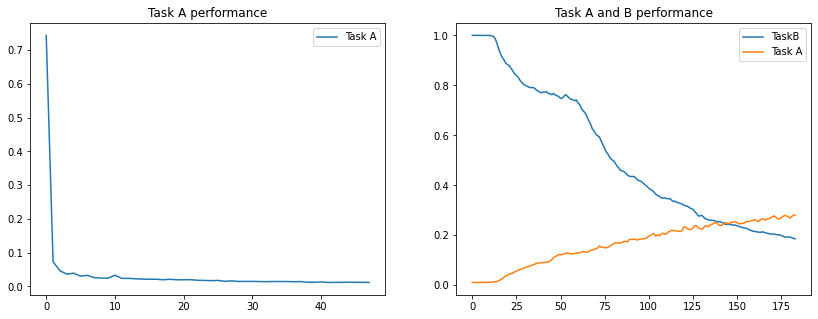

In [ ]:
import matplotlib.pyplot as plt

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(14,5))
ax1.set_title("Task A performance")
ax1.plot(taskA_callback.main_task_preds, label='Task A')
ax1.legend()
ax2.set_title("Task A and B performance")
ax2.plot(taskB_callback.main_task_preds, label="TaskB")
ax2.plot(taskB_callback.previous_task_preds, label='Task A')
ax2.legend()
plt.show()
fig.savefig('/content/drive/My Drive/hw3_1b_exp.png')

In [ ]:
import numpy as np

a = np.random.randint(1,5,(3,3))
b = np.random.randint(1,5,(3,3))
c = np.random.randint(1,5,(3,3))
print(a)
print(b)
print(c)

d = np.add.reduce([a,b,c])
print(d)
print(a+b+c)
e = K.sum(a+b+c)
print(e)